<h1 style="text-align: center;">Chatbot</h1>
<h2 style="text-align: center;">University of Denver</h2>
<h3 style="text-align: center;">Alex Liddle</h3>

A chatbot is an intelligent piece of software that is capable of communicating and performing actions similar to a human. The goal of this project is to build a model that predicts answers using predefined patterns and responses. You are provided with a file named intents.json that contains these patterns. Words and classes files are provided as extra help. Feel free to make a more complex bot by extending the intents file. 

#### Possible chat with your bot
<code>
You: Hello, how are you? 
Bot: Hi there, how can I help?
You: what can you do?
Bot: I can guide you through Adverse drug reaction list, Blood pressure tracking, Hospitals and Pharmacies
You: thanks
Bot: My pleasure
You: see ya. got to go!
Bot: See you
</code>

#### Load the necessary libraries

In [1]:
import nltk
import string
import re
import sklearn
import urllib.request
import requests
import json
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import spatial
#nltk.download('stopwords') #<---uncomment if you haven't downloaded the stopwords library
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.utils import simple_preprocess

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

First, the data, which is provided by the University of Denver, is loaded.

In [2]:
# Load pickle files
classes = pickle.load(urllib.request.urlopen("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectPCB/data/classes.pkl"))
words   = pickle.load(urllib.request.urlopen("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectPCB/data/words.pkl"))

In [3]:
# Load json file with answer patterns
intents = json.loads(requests.get("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectPCB/data/intents.json").text)

The answer patterns in the data file are for a hypothetical medical application. Let's take a peek!

In [4]:
intents

{'intents': [{'tag': 'greeting',
   'patterns': ['Hi there',
    'How are you',
    'Is anyone there?',
    'Hey',
    'Hola',
    'Hello',
    'Good day'],
   'responses': ['Hello, thanks for asking',
    'Good to see you again',
    'Hi there, how can I help?'],
   'context': ['']},
  {'tag': 'goodbye',
   'patterns': ['Bye',
    'See you later',
    'Goodbye',
    'Nice chatting to you, bye',
    'Till next time'],
   'responses': ['See you!', 'Have a nice day', 'Bye! Come back again soon.'],
   'context': ['']},
  {'tag': 'thanks',
   'patterns': ['Thanks',
    'Thank you',
    "That's helpful",
    'Awesome, thanks',
    'Thanks for helping me'],
   'responses': ['Happy to help!', 'Any time!', 'My pleasure'],
   'context': ['']},
  {'tag': 'noanswer',
   'patterns': [],
   'responses': ["Sorry, can't understand you",
    'Please give me more info',
    'Not sure I understand'],
   'context': ['']},
  {'tag': 'options',
   'patterns': ['How you could help me?',
    'What you can do

#### Explode patterns into individual rows

Next, a dataframe is created where each individual pattern is separated into its own row.

In [5]:
df = pd.DataFrame(intents['intents'])
# explode pattern fields into new rows
df_intents = pd.DataFrame({
              col:np.repeat(df[col].values, df['patterns'].str.len())
              for col in df.columns.difference(['patterns'])
          }).assign(**{'patterns':np.concatenate(df['patterns'].values)})[df.columns.tolist()]
# re-add rows with no pattern, since they were dropped by the previous step as they contained no patterns
df_intents = df_intents.append(pd.DataFrame([{'context':d['context'], 
                                              'patterns':'', 
                                              'responses':d['responses'], 
                                              'tag':d['tag']} 
                                             for d in intents['intents'] if d['patterns']==[]])).reset_index(drop=True)
# remove duplicate patterns
df_intents = df_intents.copy()[:48]

df_intents.head()

,tag,patterns,responses,context
0,greeting,Hi there,"[Hello, thanks for asking, Good to see you aga...",[]
1,greeting,How are you,"[Hello, thanks for asking, Good to see you aga...",[]
2,greeting,Is anyone there?,"[Hello, thanks for asking, Good to see you aga...",[]
3,greeting,Hey,"[Hello, thanks for asking, Good to see you aga...",[]
4,greeting,Hola,"[Hello, thanks for asking, Good to see you aga...",[]


#### Data Preprocessing

Now it is time to preprocess the text patterns (e.g., normalize, remove punctuation, remove stopwords, stem, and lemmatize.

In [6]:
def preprocess_patterns(model_type='cluster'):
    '''
    Preprocesses text by normalizing, removing punctuation, removing stopwords, stemming,
    and lemmatizing
    
    Args: model_type (str, default='cluster') -- possible values are ['cluster', 'word2vec', 'bow'].
    Returns: preprocessed (list) -- If model_type=='cluster', returns a list of tfidf vectors.
                                    Elif model_type=='word2vec', returns a list of
                                    TaggedDocument objects.
                                    Elif model_type=='bow', returns a list of bow vectors.
                                    Else, raises ValueError
             model -- If model_type=='cluster', returns a fitted tfidf vectorizer.
                      Elif model_type=='word2vec', returns a word2vec model object.
                      Else, returns a word_freq dictionary.
    '''
    stop = stopwords.words()
    processed_list = []
    
    if model_type not in ['cluster', 'word2vec', 'bow']:
        raise ValueError("'model_type' must be one of the following ['cluster', 'word2vec', 'bow']")
    for idx, val in df_intents.patterns.items():
        # Normalize words (i.e., convert to same case)
        lowered = val.replace("[^\w\s]", "").lower().split()
        # Remove punctuation
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in lowered]
        # Remove stop words
        stops_removed = [item for item in stripped if (item in words) or (item not in stop)]
        # Lemmatize and stem words
        porter = nltk.PorterStemmer()
        lemmatizer = WordNetLemmatizer()
        lemmatized = [lemmatizer.lemmatize(word) for word in stops_removed]
        stemmed = ' '.join([porter.stem(word) for word in lemmatized])
        df_intents.at[idx, 'stemmed_pattern'] = ' '.join(simple_preprocess(stemmed))
        
        if stemmed == '':
            continue
        if model_type=='cluster':
            processed_list.append(stemmed)
        elif model_type=='word2vec':
            processed_list.append(TaggedDocument(simple_preprocess(stemmed), [idx]))
        else:
            for word in simple_preprocess(stemmed):
                processed_list.append(word)
    
    if model_type=='cluster':
        tfidf = TfidfVectorizer(
            min_df = 0,
            max_df = 0.95,
            max_features = 8000,
            stop_words = 'english', 
        )

        tfidf.fit(processed_list)
        patterns_tfidf = tfidf.transform(processed_list)
        
        return patterns_tfidf, tfidf
    
    elif model_type=='word2vec':
        word2vec_model = gensim.models.doc2vec.Doc2Vec(vector_size=15, min_count=1, epochs=1000)
        word2vec_model.build_vocab(processed_list)
        word2vec_model.train(processed_list, total_examples=word2vec_model.corpus_count, epochs=1000)
        
        return processed_list, word2vec_model
    
    else:
        word_freq = {}
        for word in processed_list:
            if word not in word_freq.keys():
                word_freq[word] = 1
            else:
                word_freq[word] += 1

        bow_vec = []
        for sentence in df_intents.stemmed_pattern:
            sentence_tokens = sentence.split()
            sent_vec = []
            for token in word_freq:
                if token in sentence_tokens:
                    sent_vec.append(1)
                else:
                    sent_vec.append(0)
            bow_vec.append(sent_vec)
        
        return bow_vec, word_freq

### Models

#### Clustering Model
The first model will use clustering. User prompts will be clustered with those from the dataset. Ideally, semmantically similar prompts will cluster together, allowing the program to give a coherent response.

In [7]:
# Transform data for clustering
patterns_tfidf, tfidf = preprocess_patterns(model_type='cluster')

Let's inspect the transformed data

In [8]:
str(patterns_tfidf)

'  (0, 19)\t1.0\n  (2, 1)\t1.0\n  (3, 18)\t1.0\n  (4, 21)\t1.0\n  (5, 16)\t1.0\n  (6, 14)\t0.7071067811865475\n  (6, 10)\t0.7071067811865475\n  (7, 5)\t1.0\n  (8, 24)\t1.0\n  (9, 15)\t1.0\n  (10, 34)\t0.595985531506885\n  (10, 7)\t0.595985531506885\n  (10, 5)\t0.538147277674905\n  (11, 50)\t0.7071067811865475\n  (11, 49)\t0.7071067811865475\n  (12, 48)\t1.0\n  (13, 48)\t1.0\n  (14, 17)\t1.0\n  (15, 48)\t0.615369689973343\n  (15, 2)\t0.7882386343374141\n  (16, 48)\t0.7271369414361715\n  (16, 17)\t0.6864924387047899\n  (17, 17)\t1.0\n  (19, 40)\t0.804975269538045\n  (19, 17)\t0.5933083645391759\n  :\t:\n  (36, 4)\t0.39516747570546445\n  (37, 38)\t1.0\n  (38, 38)\t1.0\n  (39, 38)\t0.4925771983882054\n  (39, 33)\t0.6683075559684937\n  (39, 25)\t0.5574340447653383\n  (40, 38)\t0.5933083645391759\n  (40, 27)\t0.804975269538045\n  (41, 44)\t0.7271369414361715\n  (41, 38)\t0.6864924387047899\n  (42, 30)\t0.7746836041079114\n  (42, 22)\t0.6323490440621989\n  (43, 51)\t0.6151150105288973\n  (43,

The TF-IDF in TF-IDF vectorization stands for Term Frequency Inverse Document Frequency. It is the process of turning text into a meaningful numerical representation that can be used in machine learning applications such as this. The mathematical expression for TF-IDF is
<p/>
<div class="math">
\begin{equation}
  TF(t, d)xIDF(t)
\end{equation}
</div>
<p/>
where TF(t, d) returns the number of times a term appears in a document and IDF(t) returns the inverse document frequency:
<p/>
<div class="math">
\begin{equation}
  IDF(t) = log (\frac{1 + NumberOfDocuments}{1 + DocumentFreqOfTerm}) + 1
\end{equation}
</div>

(Chaudhary, M. (2021, January 28). TF-IDF vectorizer scikit-learn. Retrieved April 10, 2021, from https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a)

Next, we will determine the ideal number of clusters by analyzing the inertia (i.e., the sum of squared distances of samples to their closest cluster center) as a function of k. This is known as the elbow method. The ideal number of clusters is where the "elbow" occurs in the plot of inertias versus k clusters.
(Elbow method for optimal value of k in KMeans. (2021, February 09). Retrieved April 23, 2021, from https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/)

In [9]:
def find_optimal_clusters(data, max_k):    
    k_list = range(2, max_k+1)
    
    sse = []
    for k in k_list:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            sse.append(MiniBatchKMeans(n_clusters=k, random_state=42).fit(data).inertia_)

    plt.style.use("dark_background")
    f, ax = plt.subplots(1, 1, figsize=(12,12))
    ax.plot(k_list, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(k_list)
    ax.set_xticklabels(k_list)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')

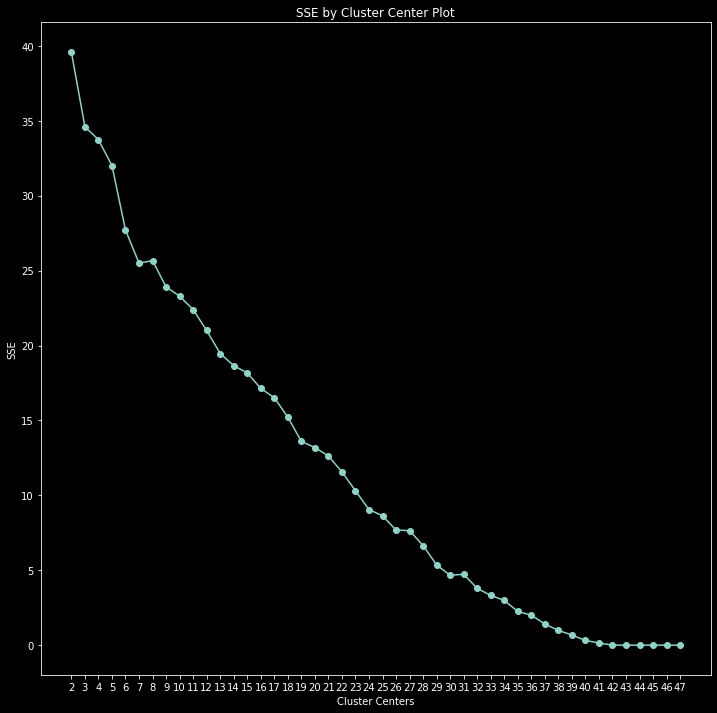

In [10]:
find_optimal_clusters(patterns_tfidf, patterns_tfidf.shape[0])

The "elbow" is located approximately where k clusters equals 42. Now we will create the cluster model using sklearn's MiniBatchKmeans module.

In [11]:
n_clusters = 42

model = MiniBatchKMeans(n_clusters=n_clusters, random_state=42).fit(patterns_tfidf)

pattern_clusters = model.predict(patterns_tfidf)

Now we will test the accuracy of the model, where accuracy is defined as the total number of times the model's response equals the expected response divided by the total number of prompts.

In [12]:
user_prompt = ''

stop = stopwords.words()
prompts = df_intents.patterns.values
responses = df_intents.responses.values

i = 0

missed = 0

print('Testing Chatbot')
print('-----------------------')

while True:
    user_prompt = prompts[i] #input("User: ")
    if user_prompt.lower()=='q':
        break
    lowered = user_prompt.replace("[^\w\s]", "").lower().split()
    # Remove punctuation
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in lowered]
    # Remove stop words
    stops_removed = [item for item in stripped if (item in words) or (item not in stop)]
    # Stem and lemmatize words
    porter = nltk.PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(word) for word in stops_removed]
    stemmed = ' '.join([porter.stem(word) for word in lemmatized])
    
    # vectorize
    test_vector = tfidf.transform([stemmed])

    predicted_cluster = model.predict(test_vector)[0]

    response = np.random.choice(list(df_intents.loc[np.where(pattern_clusters == predicted_cluster)[0]]['responses'])[0])
                                     #df_intents[df_intents.patterns_cluster==predicted_cluster].responses)[0])

    if user_prompt == "":
        response = "Sorry, can't understand you"
        
    r = responses[i]
    if response not in r:
        r = r[0]
        missed +=1
    else:
        r = response
    
    print('\nprompt:', user_prompt)
    print('predicted response:', response)
    print('expected response:', r)
        
    i += 1
    if i==len(prompts):
        break

print('-----------------------')
print('\n\nModel Accuracy:',(len(prompts)-missed)/len(prompts))

Testing Chatbot
-----------------------

prompt: Hi there
predicted response: Good to see you again
expected response: Good to see you again

prompt: How are you
predicted response: Hi there, how can I help?
expected response: Hi there, how can I help?

prompt: Is anyone there?
predicted response: Hello, thanks for asking
expected response: Hello, thanks for asking

prompt: Hey
predicted response: Hi there, how can I help?
expected response: Hi there, how can I help?

prompt: Hola
predicted response: Hi there, how can I help?
expected response: Hi there, how can I help?

prompt: Hello
predicted response: Good to see you again
expected response: Good to see you again

prompt: Good day
predicted response: Good to see you again
expected response: Good to see you again

prompt: Bye
predicted response: Have a nice day
expected response: Have a nice day

prompt: See you later
predicted response: Have a nice day
expected response: Have a nice day

prompt: Goodbye
predicted response: See you!


#### Word2Vec Model

The second model will be a Word2Vec model, or, more specifically, a Doc2Vec model which inherits the Word2Vec class but works on phrases instead of individual words.

In [13]:
patterns_word2vec, word2vec_model = preprocess_patterns(model_type='word2vec')

In [14]:
user_prompt = ''

prompts = df_intents.patterns.values
responses = df_intents.responses.values

i = 0

missed = 0

print('Testing Chatbot')
print('-----------------------')

while True:
    user_prompt = prompts[i] #input("User: ")
    if user_prompt.lower()=='q':
        break
    lowered = user_prompt.replace("[^\w\s]", "").lower().split()
    # Remove punctuation
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in lowered]
    # Remove stop words
    stops_removed = [item for item in stripped if (item in words) or (item not in stop)]
    # Stem and lemmatize words
    porter = nltk.PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(word) for word in stops_removed]
    stemmed = ' '.join([porter.stem(word) for word in lemmatized])
    
    # vectorize
    inferred_vector = word2vec_model.infer_vector(simple_preprocess(stemmed))
    # find similar phrases
    similar = word2vec_model.docvecs.most_similar([inferred_vector])
    similar = ' '.join(patterns_word2vec[similar[0][0]].words)
    response = np.random.choice(list(df_intents.loc[df_intents.stemmed_pattern==similar]['responses'])[0])
        
    if user_prompt == "":
        response = "Sorry, can't understand you"
    r = responses[i]
    if response not in r:
        r = r[0]
        missed +=1
    else:
        r = response
    
    print('\nprompt:', user_prompt)
    print('predicted response:', response)
    print('expected response:', r)
        
    i += 1
    if i==len(prompts):
        break

print('-----------------------')
print('\n\nModel Accuracy:',(len(prompts)-missed)/len(prompts))

Testing Chatbot
-----------------------

prompt: Hi there
predicted response: Hello, thanks for asking
expected response: Hello, thanks for asking

prompt: How are you
predicted response: Hello, thanks for asking
expected response: Hello, thanks for asking

prompt: Is anyone there?
predicted response: Good to see you again
expected response: Good to see you again

prompt: Hey
predicted response: Hello, thanks for asking
expected response: Hello, thanks for asking

prompt: Hola
predicted response: Good to see you again
expected response: Good to see you again

prompt: Hello
predicted response: Hi there, how can I help?
expected response: Hi there, how can I help?

prompt: Good day
predicted response: Hi there, how can I help?
expected response: Hi there, how can I help?

prompt: Bye
predicted response: Have a nice day
expected response: Have a nice day

prompt: See you later
predicted response: See you!
expected response: See you!

prompt: Goodbye
predicted response: Bye! Come back agai

#### Bag-of-Words Model

The final model is a bag-of-words model.

In [15]:
bow_vec, word_freq = preprocess_patterns(model_type='bow')

In [16]:
user_prompt = ''

prompts = df_intents.patterns.values
responses = df_intents.responses.values

i = 0

missed = 0

print('Testing Chatbot')
print('-----------------------')

while True:
    user_prompt = prompts[i] #input("User: ")
    if user_prompt.lower()=='q':
        break
    lowered = user_prompt.replace("[^\w\s]", "").lower().split()
    # Remove punctuation
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in lowered]
    # Remove stop words
    stops_removed = [item for item in stripped if (item in words) or (item not in stop)]
    # Stem and lemmatize words
    porter = nltk.PorterStemmer()
    lemmatized = [lemmatizer.lemmatize(word) for word in stops_removed]
    stemmed = ' '.join([porter.stem(word) for word in lemmatized])
    
    # vectorize
    sent_vec = []
    sentence_tokens = simple_preprocess(stemmed)
    for token in word_freq:
        if token in sentence_tokens:
            sent_vec.append(1)
        else:
            sent_vec.append(0)
    
    # find similar phrases
    similar = []
    for vec in bow_vec:
        similar.append(1 - pairwise_distances([vec], [sent_vec], metric = 'cosine')[0][0])
    response = np.random.choice(list(df_intents.loc[np.argmax(similar)]['responses']))
        
    if user_prompt == "":
        response = "Sorry, can't understand you"
    r = responses[i]
    if response not in r:
        r = r[0]
        missed +=1
    else:
        r = response
    
    print('\nprompt:', user_prompt)
    print('predicted response:', response)
    print('expected response:', r)
        
    i += 1
    if i==len(prompts):
        break

print('-----------------------')
print('\n\nModel Accuracy:',(len(prompts)-missed)/len(prompts))

Testing Chatbot
-----------------------

prompt: Hi there
predicted response: Good to see you again
expected response: Good to see you again

prompt: How are you
predicted response: Good to see you again
expected response: Good to see you again

prompt: Is anyone there?
predicted response: Hi there, how can I help?
expected response: Hi there, how can I help?

prompt: Hey
predicted response: Hi there, how can I help?
expected response: Hi there, how can I help?

prompt: Hola
predicted response: Hi there, how can I help?
expected response: Hi there, how can I help?

prompt: Hello
predicted response: Good to see you again
expected response: Good to see you again

prompt: Good day
predicted response: Good to see you again
expected response: Good to see you again

prompt: Bye
predicted response: Bye! Come back again soon.
expected response: Bye! Come back again soon.

prompt: See you later
predicted response: See you!
expected response: See you!

prompt: Goodbye
predicted response: Bye! Co